In [1]:
import torch
import utils
import dlc_practical_prologue as prologue

from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

from IPython.display import display,clear_output

## A. First attempts at implementing baseline methods
This notebook contains the first architectures for the classification task of miniproject 1.

### Load data and prepare it for training

In [2]:
# Download data
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(1000)

In [3]:
print("Train inputs :" , train_input.shape)
print("Train targets :" , train_target.shape)
print("Train classes :" , train_classes.shape)
print("Test inputs :" , test_input.shape)
print("Test targets :" , test_target.shape)
print("Test classes :" , test_classes.shape)

Train inputs : torch.Size([1000, 2, 14, 14])
Train targets : torch.Size([1000])
Train classes : torch.Size([1000, 2])
Test inputs : torch.Size([1000, 2, 14, 14])
Test targets : torch.Size([1000])
Test classes : torch.Size([1000, 2])


In [4]:
train_input, train_target, train_classes = Variable(train_input), Variable(train_target), Variable(train_classes) 
test_input, test_target, test_classes = Variable(test_input), Variable(test_target), Variable(test_classes)

### Define training and evaluation functions

In [7]:
def accuracy(model, X, Y, mini_batch_size=100):
    """
    Given a trained classification model, an input set and an output set,
    this method predicts the class for the inputs and compares the predictions to the true targets.
    It counts the errors and computes the accuracy of the model on the given sets.
    
    Parameters
    ----------
    model: pytorch Model
        trained classification model
    
    X: tensor
        input data (features)
        
    Y: tensor
        target data (class)
        
    mini_batch_size: int
        the predictions are done in batches and not at once, specifies batch size
    ----------
    
    Returns
    ----------
    accuracy: float
        accuracy value, between 0 and 1
    ----------
    """
    
    nb_errors = 0
    
    # Proceed in batches
    for b in range(0, X.size(0), mini_batch_size):
        
        # Predict batch
        output = model(X.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.data.max(1)
        
        # Count errors in batch
        for k in range(mini_batch_size):
            if Y[b + k] != predicted_classes[k]:
                nb_errors = nb_errors + 1
    
    accuracy = 1 - nb_errors/X.shape[0]
    return accuracy


def train_model(model, X, Y, tX, tY,
                mini_batch_size=100, eta=1e-3, epochs=25,
                criterion=nn.CrossEntropyLoss(), opt=torch.optim.Adam):
    """
    This method trains a pytorch model on a given training set over the course
    of a specified number of epochs, evaluating its performance on a validation
    set at each epoch. It returns the training and validation history as a dict.
    """
    
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    optimizer = opt(model.parameters(), lr=eta)
    
    for e in range(epochs):
        sum_loss = 0
        
        with torch.no_grad():
            # Compute validation loss and accuracy
            val_acc = accuracy(model, tX, tY)
            history['val_acc'].append(val_acc)

            # Compute training accuracy w/o messing with training
            train_acc = accuracy(model, X, Y)
            history['train_acc'].append(train_acc)
            
            # Compute validation loss
            val_output = model(tX)
            val_loss = criterion(val_output, tY)
            history['val_loss'].append(val_loss.item())
            
        for b in range(0, X.size(0), mini_batch_size):
            # Classify batch, compute loss and perform backpropagation with parameter updates
            output = model(X.narrow(0, b, mini_batch_size))
            loss = criterion(output, Y.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
            sum_loss = sum_loss + loss.item()

                
        history['train_loss'].append(sum_loss)
        clear_output(wait=True)
        print('Epoch ' + str(e+1) + '/' + str(epochs))
    
    return history

### Architecture 1

Epoch 50/50


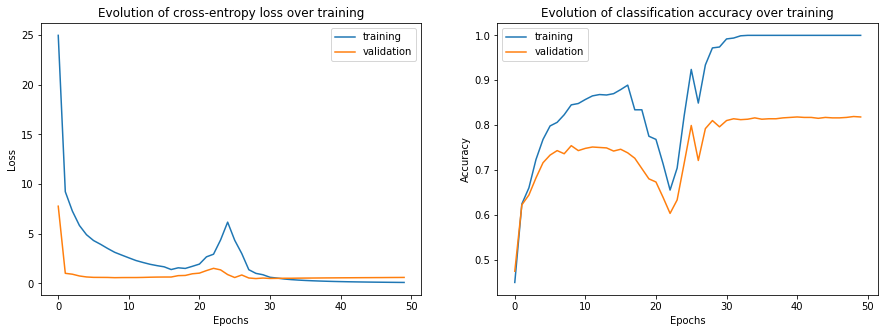

In [8]:
class ConvNet1(nn.Module):
    def __init__(self, nb_hidden=100):
        super(ConvNet1, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = F.relu(x)
        x = self.fc1(x.view(-1, 256))
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
model1 = ConvNet1()
hist1 = train_model(model1, train_input, train_target, test_input, test_target, eta=0.0005, epochs=50)
utils.plot_hist(hist1)

### Architecture 2

Epoch 50/50


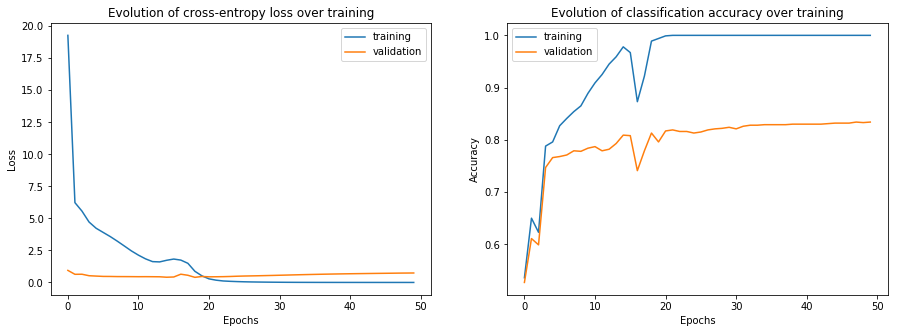

In [10]:
class ConvNet2(nn.Module):
    def __init__(self, nb_hidden=100):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(512, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.pool2(x)
        x = F.relu(x)
        x = self.fc1(x.view(-1, 512))
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
model2 = ConvNet2()
hist2 = train_model(model2, train_input, train_target, test_input, test_target, eta=0.0005, epochs=50)
utils.plot_hist(hist2)